In [63]:
import requests
import xml.etree.ElementTree as ET

# URL of the XML file
url = "https://support.zerodha.com/sitemap.xml"

try:
    # Fetch the XML data from the web
    response = requests.get(url)
    response.raise_for_status()  # Raise an error if the request failed

    # Parse the XML data
    root = ET.fromstring(response.content)

    # Namespace in the XML (optional, for sitemaps with namespaces)
    namespace = {'ns': 'http://www.sitemaps.org/schemas/sitemap/0.9'}

    # Extract URLs
    urls = [url.text for url in root.findall('ns:url/ns:loc', namespace)]

    # Print the extracted URLs
    print(f"Totla number or pages: {len(urls)}")
    for url in urls[:5]:
        print(url)

except requests.exceptions.RequestException as e:
    print(f"An error occurred while fetching the XML: {e}")


Totla number or pages: 1312
https://support.zerodha.com/category/account-opening/company-partnership-and-huf-account-opening/company/articles/are-corporate-account-holders-allowed-to-invest-in-mutual-funds-through-coin
https://support.zerodha.com/category/account-opening/company-partnership-and-huf-account-opening/company/articles/can-an-overseas-corporate-body-i-e-ocbs-invest-shares-in-the-indian-market
https://support.zerodha.com/category/account-opening/company-partnership-and-huf-account-opening/company/articles/change-director-partner-or-authorised-person
https://support.zerodha.com/category/account-opening/company-partnership-and-huf-account-opening/company/articles/charges-society-account
https://support.zerodha.com/category/account-opening/company-partnership-and-huf-account-opening/company/articles/charges-trust-account


In [4]:
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma

# model = "gemma3:4b"

model = "nomic-embed-text"

embeddings = OllamaEmbeddings(model=model)

vector_store = Chroma(
    collection_name="support_collection",
    embedding_function=embeddings,
    persist_directory="./zerodha_db",  # Where to save data locally, remove if not necessary
)

In [5]:
from langchain_community.document_loaders import WebBaseLoader
# fixes a bug with asyncio and jupyter
import nest_asyncio

nest_asyncio.apply()

bs_get_text_kwargs = {
    'separator': '\n',  
    'strip': True
    }

loader = WebBaseLoader(urls[:100], verify_ssl=False, bs_get_text_kwargs=bs_get_text_kwargs)

loader.requests_per_second = 50
docs = loader.aload()

USER_AGENT environment variable not set, consider setting it to identify your requests.
/var/folders/_m/ls8dj8j970v4yfv_9z69x2wh0000gn/T/ipykernel_83324/3205032468.py:15: LangChainDeprecationWarning: See API reference for updated usage: https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html
  docs = loader.aload()
Fetching pages: 100%|##########| 100/100 [00:00<00:00, 140.94it/s]


In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [ ]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [16]:
from huggingface_hub import InferenceClient
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma


# llm_model = "gemma3:4b"
llm_model = "llama3.2"
embeddings_model = "nomic-embed-text"

# embeddings = OllamaEmbeddings(model=embeddings_model)
# load from disk
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

# create the open-source embedding function
embeddings = SentenceTransformerEmbeddings(model_name="BAAI/bge-large-en-v1.5", model_kwargs = {'device': 'cpu'})
print("Embeddings loaded")


vector_store = Chroma(
    embedding_function=embeddings,
    persist_directory="./zerodha_db",  # Where to save data locally, remove if not necessary
)

retriever_zerodha = vector_store.as_retriever(search_kwargs={'k': 4})
print("Zerodha retriever loaded.")

model = "mistralai/Mistral-7B-Instruct-v0.3"
# model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
client = InferenceClient(
    model=model
)


Embeddings loaded
Zerodha retriever loaded.


In [4]:
retriever_zerodha.invoke("account")

[Document(id='f5c1b1aa-b38c-4bb3-aa4b-30ed440f031c', metadata={'description': 'How can a minor account be converted to an individual account?', 'language': 'No language found.', 'source': 'https://support.zerodha.com/category/account-opening/online-account-opening/minor-account/articles/minor-account-holder-completes-18-years', 'title': 'How can a minor account be converted to an individual account?'}, page_content="How can a minor account be converted to an individual account?.Minor account\nHow can a minor account be converted to an individual account?\nOnce a minor turns major (18 years of age), the minor account must be converted to an individual account. Clients must submit a new mobile number, email ID and the following documents:\nAccount opening forms\n(PDF).\nA passport-size photograph to affix and sign across on the form.\nSelf-attested copy of the PAN with the signature under\nApplicant signature.\nSelf-attested address proof. Any one of the following documents: Driving lice

In [17]:
from langchain import hub
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langchain.chat_models import init_chat_model

# llm_model = "gemma3:4b"
llm_model = "llama3.2"
llm = init_chat_model(llm_model, model_provider="ollama")

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [18]:
response = graph.invoke({"question": "How and where to contact to zerodha?"})
print(response["answer"])

To contact Zerodha, you can reach out to them through their official phone numbers:

- 080 37074647
- 080 37096498
- 080 37096499
- 080 71173891
- 080 47186626
- 080 71173861
- 080 71909543
- 080 71909545
- 080 37074651
- 080 71966807
- 080 47192020
- 080 47092457
- 080 47181888

Or, you can create a ticket on their website and mention the number if you receive an unsolicited call claiming to be from Zerodha.


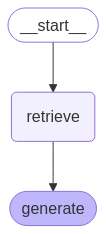

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [21]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [22]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

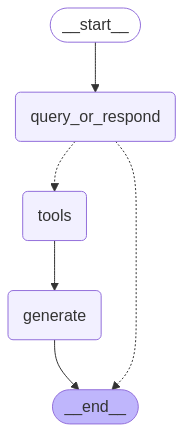

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
input_message = "Hi good mornig"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hi good mornig
================================== Ai Message ==================================
Tool Calls:
  retrieve (2c05a13d-c3bf-496f-a62f-ebdab53f9d45)
 Call ID: 2c05a13d-c3bf-496f-a62f-ebdab53f9d45
  Args:
    query:
================================= Tool Message =================================
Name: retrieve

Source: {'description': 'Console', 'language': 'No language found.', 'source': 'https://support.zerodha.com/category/console/profile', 'title': 'Console'}
Content: Console.
Show
more
less
Home
Console
Profile
☰
View all categories
×
Console
IPO
Portfolio
Funds statement
Profile
Reports
Referral program
Account
How to view the bank account details linked with Zerodha?
Why is Zerodha asking for the income proof to be updated?
How to update the income details for the Zerodha account?
How to submit the currency declaration form to trade in the currency segment?
How to log in to multiple Zerodha

In [ ]:
from bs4 import BeautifulSoup
import requests
# Example HTML content
resp = requests.get("https://support.zerodha.com/category/your-zerodha-account/account-modification-and-segment-addition/account-modification/articles/change-contact-details")
html_content = resp.text
# Parse the HTML content
soup = BeautifulSoup(html_content, 'html.parser')

# Find the element with the class "article-content"
article_content = soup.find('div', class_='article-description')


# Extract text, including `a` tags with href and text
if article_content:
    result = []
    # Iterate over child elements
    for element in article_content.find_all(['p', 'a'], recursive=True):
        if element.name == 'a':
            # Include link text and href
            link_text = f"{element.get_text()} {element.get('href', "")}"
            result.append(link_text)
        elif element.name == 'p' and 'ticket-link-container' not in element.get('class', []):
            # Include text from paragraphs that do not have the class "exclude"
            result.append(element.get_text(strip=False))

    # Combine all collected text
    output_text = ' '.join(result)
    print(output_text)
else:
    print("No content found with class 'article-content'.")















      Table of contents
     





        Indian mobile number
       





        International mobile number
       





        Offline
       








 The email ID can be changed online on Console. However, only Indian residents and NRIs with Indian mobile numbers can change the mobile number on Console. Non-individual account holders (company, partnership, LLP or HUF), joint accounts and clients whose mobile number is not linked with Aadhaar can only change their contact details offline.




 Indian mobile number


 To update the contact details on Console, follow these steps:




   Log in to
  


    console.zerodha.com/account/personal.
   



  Click on the edit icon.
 

  Click on the checkbox and click on
  
   Continue.
  




   Enter the new email id or phone number and click on
   
    Continue.
   




   Enter the OTP and click on
   
    Verify.
   
   If the OTP verification fails, retry after 5 minutes.
  



   Complete the In-Person Verification (

In [77]:
from typing import List
from langchain.document_loaders import WebBaseLoader
from langchain.schema import Document
from bs4 import BeautifulSoup
import nest_asyncio

nest_asyncio.apply()

class CustomWebLoader(WebBaseLoader):
    def load(self) -> List[Document]:
        # Retrieve the HTML content using WebBaseLoader's mechanism.
        html_content = self.web_page_content  
        # Parse the HTML using BeautifulSoup.
        soup = BeautifulSoup(html_content, 'html.parser')
        # Change the target container class if needed.
        article_content = soup.find('div', class_='article-description')
        
        if article_content:
            result = []
            # Iterate over the desired tags and apply your extraction logic.
            for element in article_content.find_all(['p', 'a'], recursive=True):
                if element.name == 'a':
                    # Concatenate the link text and its href.
                    link_text = f"{element.get_text()} {element.get('href', '')}"
                    result.append(link_text)
                elif element.name == 'p' and 'ticket-link-container' not in element.get('class', []):
                    # Get the text from paragraphs, preserving formatting if needed.
                    result.append(element.get_text(strip=False))
            output_text = ' '.join(result)
        else:
            output_text = ""
        
        # Return a list with a Document that contains the parsed text and metadata.
        return [Document(page_content=output_text, metadata={"source": self.web_path})]


bs_get_text_kwargs = {
    'separator': '\n',  
    'strip': True
    }

loader = CustomWebLoader(urls[:100], verify_ssl=False, bs_get_text_kwargs=bs_get_text_kwargs)

loader.requests_per_second = 50
docs = loader.load()

AttributeError: 'CustomWebLoader' object has no attribute 'web_page_content'

In [76]:
print(docs[0].metadata['title'],docs[0].metadata['source'], "\n", docs[0].page_content)

Can non-individual account holders invest in mutual funds through Coin? https://support.zerodha.com/category/account-opening/company-partnership-and-huf-account-opening/company/articles/are-corporate-account-holders-allowed-to-invest-in-mutual-funds-through-coin 
 Can non-individual account holders invest in mutual funds through Coin?
Signup
About
Products
Pricing
Support
Signup
About
Products
Pricing
Support
Kite
Trading platform
Console
Backoffice
Kite Connect
Trading APIs
Coin
Mutual funds
Varsity
Trading Q&A
Utilities
Brokerage calculator
Margin calculator
Holiday calendar
Updates
Z-Connect
Pulse News
Circulars / Bulletin
IPOs
Education
Varsity
Trading Q&A
Support Portal
Track tickets
Search for an answer or browse help topics to create a ticket
✖
Featured
Surveillance measure on scrips - March 2025
Current Takeovers and Delisting – March 2025
Show
more
less
Home
Account Opening
Company, Partnership, HUF and LLP
Company
☰
View all categories
×
Account Opening
Resident individual
Mi

In [ ]:
from ollama import 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gradio/oauth.py:163: UserWarning: Gradio does not support OAuth features outside of a Space environment. To help you debug your app locally, the login and logout buttons are mocked with your profile. To make it work, your machine must be logged in to Huggingface.
  warnings.warn(


ValueError: Your machine must be logged in to HF to debug a Gradio app locally. Please run `huggingface-cli login` or set `HF_TOKEN` as environment variable with one of your access token. You can generate a new token in your settings page (https://huggingface.co/settings/tokens).

In [9]:
from ollama import chat, generate

llm_model = "gemma3:4b"
# llm_model = "llama3.2"

def text_generation(prompt):
    stream = generate(
        model='llama3.2',
        prompt = prompt,
        stream=True)
    return stream

stream = text_generation( 'Why is the sky blue?')
for chunk in stream:
  print(chunk['response'], end='', flush=True)

The sky appears blue because of a phenomenon called Rayleigh scattering, named after the British physicist Lord Rayleigh. When sunlight enters Earth's atmosphere, it encounters tiny molecules of gases such as nitrogen and oxygen.

These molecules scatter the light in all directions, but they scatter shorter (blue) wavelengths more than longer (red) wavelengths. This is known as selective scattering.

Here's what happens:

1. Sunlight contains a broad spectrum of colors, including blue, green, yellow, orange, and red.
2. When sunlight enters the atmosphere, it encounters tiny molecules of gases like nitrogen (N2) and oxygen (O2).
3. These molecules scatter the shorter wavelengths of light (like blue and violet) more efficiently than the longer wavelengths (like red and orange).
4. As a result, the blue light is scattered in all directions by the atmosphere and reaches our eyes from all parts of the sky.
5. Our brains interpret this scattered blue light as the color of the sky.

In contr

In [2]:
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
import gradio as gr
import datetime
import bs4
import requests
from src.utils import get_logger, zerodha_examples, text_generation

# Get logger object
logger = get_logger(name=__name__, log_file='Log/Zerodha_RAG.log')

# Create the open-source embedding function
embedding_function = SentenceTransformerEmbeddings(
    model_name="BAAI/bge-large-en-v1.5", 
    model_kwargs={'device': 'cpu'}
)
logger.debug("Embeddings loaded")

# Load the vector DB from disk
db_zerodha = Chroma(persist_directory="./zerodha_db", embedding_function=embedding_function)
retriever_zerodha = db_zerodha.as_retriever(search_kwargs={'k': 4})
logger.debug("Zerodha retriever loaded.")

def construct_prompt(message, history, retrieved_docs):
    """
    Build the complete prompt by incorporating:
    1. Previous conversation turns (history)
    2. An introductory instruction for the chatbot
    3. Retrieved documents from the vector store
    4. The current user message
    """
    prompt = "<s>"

    # Incorporate the chat history: each previous user input and bot response
    for user_prompt, bot_response in history:
        prompt += f"[INST] {user_prompt} [/INST]"
        prompt += f" {bot_response}</s> "

    # Add an introductory instruction for the bot
    prompt += (
        "You are a support chatbot for Zerodha, a leading stock brokerage firm. "
        "Your goal is to assist users with their queries by providing accurate and detailed information based on the retrieved documents and the chat history provided. "
        "Always cite reference sources when required. If the user's question is not found or is outside the context of Zerodha, respond politely, asking them to rephrase their question within the Zerodha support context.\n\n"
        "If the user greeting message (such as 'hi', 'hello', 'hey') starts the conversation, respond with a friendly greeting and ask how you can assist with Zerodha-related queries, without providing detailed information or referencing retrieved documents.\n\n"
    )

    # Append the retrieved documents to the prompt
    prompt += "[Retrieved Documents for the context of user_prompt]\n"
    for doc in retrieved_docs:
        prompt += f"source: {doc.metadata['source']}, page_content: {doc.page_content}\n"

    # Add the current user message at the end
    prompt += f"[INST] {message} [/INST]"

    return prompt

def generate_1(prompt, history):
    """
    This function:
    1. Retrieves relevant documents for the current query.
    2. Constructs the full prompt using the conversation history and retrieved docs.
    3. Calls the text_generation function (streaming output).
    4. Yields partial responses for a streaming experience.
    """
    logger.info(f"User-input: {prompt}")

    # Retrieve relevant documents from the vector DB
    retrieved_docs = retriever_zerodha.invoke(prompt)

    # Build the prompt with history and context
    formatted_prompt = construct_prompt(prompt, history, retrieved_docs)

    # Generate the answer in streaming mode
    stream = text_generation(formatted_prompt)
    output = ""
    for chunk in stream:
        output += chunk.response
        yield output  # Yield each chunk for streaming to the UI

    logger.info(f"Bot-response: {output}")
    return output

# Create a Gradio ChatInterface that uses the generate_1 function.
# Ensure that the conversation history is maintained (using Gradio's internal state)
# Zerodhat_bot = gr.ChatInterface(
#     fn=generate_1, 
#     type="messages",
#     title="Zerodha Support Chatbot",
#     examples=zerodha_examples
# ).launch(show_error=True)


/var/folders/_m/ls8dj8j970v4yfv_9z69x2wh0000gn/T/ipykernel_86276/2545350589.py:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = SentenceTransformerEmbeddings(
2025-03-21 08:37:18,728 - DEBUG    -  19 - <module>           - Embeddings loaded
2025-03-21 08:37:18,924 - DEBUG    -  24 - <module>           - Zerodha retriever loaded.


In [3]:
from langchain_chroma import Chroma
from pydantic_ai.agent import Agent
from pydantic_ai import RunContext
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider

# llm_model = "gemma3:4b"
llm_model = "llama3.2"

system_prompt = "You are a support chatbot for Zerodha, a leading stock brokerage firm. Your goal is to assist users with their queries by providing accurate and detailed information based on the retrieved documents provided. Always cite reference sources when required. If the user's query is not found or is outside the context of Zerodha, respond politely, asking them to rephrase their question within the Zerodha support context.\n\n If the user greeting message (such as 'hi', 'hello', 'hey') starts the conversation, respond with a friendly greeting and ask how you can assist with Zerodha-related queries, without providing detailed information or referencing retrieved documents.\n\n"


# Load the vector DB from disk
db_zerodha = Chroma(persist_directory="./src/src/zerodha_db", embedding_function=embedding_function)
retriever = db_zerodha.as_retriever(search_kwargs={'k': 4})
logger.debug("Zerodha retriever loaded.")

# Create a RAG agent (here we use OpenAI's GPT-4 model as an example)
ollama_llm = OpenAIModel(model_name=llm_model, provider=OpenAIProvider(base_url='http://localhost:11434/v1'))
agent = Agent(ollama_llm, system_prompt=system_prompt)

# Define a tool for document retrieval using your Chroma vector retriever
@agent.tool
def retrieve_docs(context: RunContext, query: str) -> str:
    """
    Retrieve relevant documents for the given query from the Chroma vector store.
    """
    docs = retriever.invoke(query)
    logger.debug(f"retriever docs: {len(docs)} for query: {query}")
    # Combine the retrieved documents into a single string, including source information if available
    result = "\n\n".join(
        f"Source: {doc.metadata.get('source', 'unknown')}\nContent: {doc.page_content}"
        for doc in docs
    )
    return result

2025-03-21 08:37:43,109 - DEBUG    -  16 - <module>           - Zerodha retriever loaded.


In [12]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

async def main():
    user_prompt = 'What is Zerodha?'
    # Begin a node-by-node, streaming iteration
    async with agent.iter(user_prompt) as run:
        async for node in run:
            print(await node)
        #> London

asyncio.run(main())


TypeError: object ModelRequestNode can't be used in 'await' expression

In [9]:
resp2 = agent.run_stream("What is Zerodha?")
resp2

In [6]:
resp3 = agent.run_sync("How to contact Zerodha?")
resp3

2025-03-20 07:56:20,055 - DEBUG    -  29 - retrieve_docs      - retriever docs: 4 for query: Zerodha customer contact details


AgentRunResult(data='You can contact Zerodha through various channels:\n\n1. Phone: You can call them at the numbers mentioned below to verify if the call is from a legitimate source:\n   - 080 37074647\n   - 080 37096498\n   - 080 37096499\n   - 080 71173891\n   - 080 47186626\n   - 080 71173861\n   - 080 71909543\n   - 080 71909545\n   - 080 37074651\n   - 080 71966807\n   - 080 47192020\n   - 080 47092457\n   - 080 47181888\n\n2. Email: You can reach them through their email address, but you need to be logged in to your Zerodha account.\n\n3. Phone: Alternatively, a call will also be made to your unregistered number with a registered mobile number followed by a support code.\n\n4. Console login\nVisit your Zerodha console account to view details like the registered mobile number, email ID, bank account number, and demat account number.\n\nPlease note that calls are made only if there are issues with account opening, margin calls or other compliance-related requirements and never for

In [7]:
resp3.new_messages()

NameError: name 'resp3' is not defined

In [13]:
from pydantic_ai import Agent
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider


ollama_llm = OpenAIModel(model_name="llama3.2:latest", provider=OpenAIProvider(base_url='http://localhost:11434/v1'))

agent = Agent(model=ollama_llm)

In [16]:
import asyncio

async def main():
    async with agent.run_stream("Where does 'Hello world' come from ?") as result:
        async for message in result.stream_text(delta=True):
            print(message, end='', flush=True)

asyncio.run(main())

The phrase "Hello, World!" is one of the most iconic and enduring phrases in technology, but its origins are not well-documented. However, there are a few theories about where it came from.

One popular theory credits Bob Bertini, an American computer scientist, with creating the first "Hello, World!" program on November 17, 1969, while working at NASA's Ames Research Center in California. According to this story, Bertini wrote a simple program in COBOL for a computer system that was testing the limits of programming.

Another theory suggests that it came from a 1970s-era computer terminal interface. In those days, users would often be prompted by their computers with greetings like "Welcome" or "Hello." If the user entered anything other than the expected answer (usually just a space), they would receive an error message, often including "ERROR! HELLO, WORLD!" as a way of indicating that something was amiss.

A more recent theory emerges from 1980s programming culture. On January 19, 

In [22]:
resp = None
async def stream_rag_agent(query, history):
    global resp
    logger.info(f"User-input: {query}")
    output = ""
    try:
        if resp:
            async with agent.run_stream(query, message_history=resp.new_messages(), deps=retriever) as result:
                async for chunk in result.stream_text(delta=True):
                    output += chunk
                    yield output
                resp = result
        else:
            async with agent.run_stream(query, deps=retriever) as result:
                async for chunk in result.stream_text(delta=True):
                    output += chunk
                    yield output
                resp = result

        logger.info(f"Bot-response: {output}")
    except Exception as e:
        logger.error(f"Error in stream_rag_agent: {str(e)}")
        yield f"An error occurred: {str(e)}"


import asyncio

async def test_stream():
    async for output in stream_rag_agent("Test query", []):
        print(output)

test_stream()


<coroutine object test_stream at 0x15c6e28e0>

In [1]:
import asyncio
import gradio as gr
from pydantic_ai import Agent
from pydantic_ai.tools import RunContext
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider

# Create a basic agent with a simple system prompt.
# (Replace 'openai:gpt-4o' with your model identifier if needed.)

ollama_llm = OpenAIModel(model_name="llama3.2:latest", provider=OpenAIProvider(base_url='http://localhost:11434/v1'))

agent = Agent(
    ollama_llm,
    system_prompt="You are a helpful assistant.",
    result_type=str,
)

# Define an asynchronous function that streams the response.
async def stream_agent_response(user_input, history):
    # Start a streaming run of the agent.
    # Note: You can pass history if needed for conversation context.
    async with agent.run_stream(user_input) as stream:
        response = ""
        # Stream the response tokens as they are generated.
        async for chunk in stream.stream_text(delta=True):
            response += chunk
            # Yield the updated response so far.
            yield response

# Create a Gradio ChatInterface that uses our async streaming function.
chat_interface = gr.ChatInterface(
    fn=stream_agent_response,
    type="messages",
    title="Pydantic AI Chat Interface"
)

if __name__ == "__main__":
    chat_interface.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
